# basic-001
https://chatgpt.com/c/6800ad48-1980-800a-bb03-227c28f3164c

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

2025-04-18 21:43:31.188276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745000011.201508   26535 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745000011.205975   26535 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-18 21:43:31.219146: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load datasets
train_df = pd.read_csv("../datasets/XAGUSD-H1-rates.csv", sep=r"\s+", engine='python')
predict_df = pd.read_csv("../datasets/new-data-for-test/rows-30-from-20240503.csv", sep=r"\s+", engine='python')

In [3]:
# Use only numerical features
features = ['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>', '<VOL>', '<SPREAD>']

In [4]:
# Normalize the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[features])
predict_scaled = scaler.transform(predict_df[features])

In [5]:
# Create sequences for training
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i][3])  # predicting 'CLOSE' price (index 3)
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled)

In [6]:
# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=64)

I0000 00:00:1745000013.479207   26535 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2258 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5
/home/saeed/repositories/machine-learning/tensorflow-course/start-tensorflow/envs/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


I0000 00:00:1745000015.458828   26576 cuda_dnn.cc:529] Loaded cuDNN version 90800


861/861 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 1.3095e-05 - loss: 0.0024
Epoch 2/10
861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 1.7354e-05 - loss: 5.4397e-05
Epoch 3/10
861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 6.4906e-05 - loss: 4.3973e-05
Epoch 4/10
861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 3.4278e-05 - loss: 4.3401e-05
Epoch 5/10
861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 3.1034e-05 - loss: 3.9585e-05
Epoch 6/10
861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 3.1067e-05 - loss: 3.3441e-05
Epoch 7/10
861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 2.6974e-05 - loss: 3.0151e-05
Epoch 8/10
861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 5.9119e-05 - loss: 3.0104e-05
Epoch 9/10
861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 2.4033e-05 - loss: 2.6467e-05
Epoch 10/10
861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 6.1649e-05 - loss: 2.5265e-05


In [7]:
# Predict next 100 candles based on the last 30 real ones
predictions = []
input_seq = predict_scaled[-30:]  # start from last 30 rows

for _ in range(100):
    pred_input = np.expand_dims(input_seq, axis=0)
    pred_close = model.predict(pred_input, verbose=0)[0][0]

    # Build the next candle with predicted CLOSE and last known values
    next_candle = input_seq[-1].copy()
    next_candle[3] = pred_close  # replace CLOSE with predicted

    predictions.append(next_candle)
    input_seq = np.vstack([input_seq[1:], next_candle])  # roll the window

In [8]:
# Inverse transform
all_candles = np.vstack([predict_scaled, predictions])
all_candles = scaler.inverse_transform(all_candles)

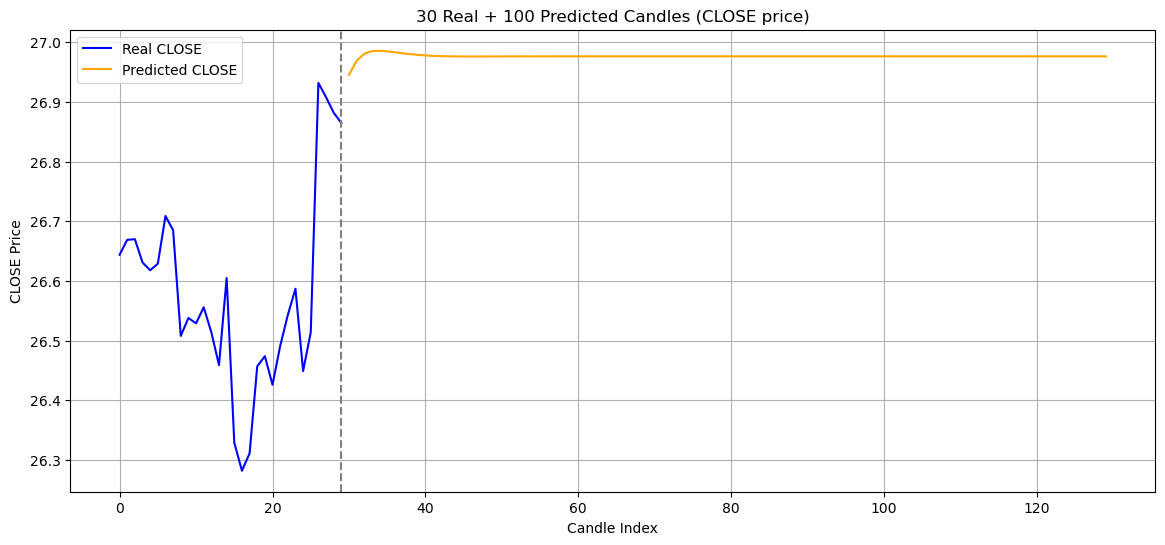

In [9]:
# Plotting
plt.figure(figsize=(14, 6))
real_closes = all_candles[:30, 3]
predicted_closes = all_candles[30:, 3]

plt.plot(range(0, 30), real_closes, label='Real CLOSE', color='blue')
plt.plot(range(30, 130), predicted_closes, label='Predicted CLOSE', color='orange')
plt.axvline(x=29, color='gray', linestyle='--')
plt.title("30 Real + 100 Predicted Candles (CLOSE price)")
plt.xlabel("Candle Index")
plt.ylabel("CLOSE Price")
plt.legend()
plt.grid(True)
plt.show()
